<h1 style="text-align: center;"> Vorhersage der Weinqualität (Ordinal Regression)

<h1 style="text-align: center;">
<img src="https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcSzbnp0DTtmWmuW2w2IAxmv9s54vxyB-3IRrg&s "style='width:350px'/>

In [1]:
# Projekt: Vorhersage der Weinqualität (Ordinal Classification)

# 1. Bibliotheken laden
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBClassifier


In [2]:
# 2. Daten laden
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")

In [3]:
# 3. Überblick anzeigen
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   id                    15000 non-null  int64  
 1   fixed acidity         15000 non-null  float64
 2   volatile acidity      15000 non-null  float64
 3   citric acid           15000 non-null  float64
 4   residual sugar        15000 non-null  float64
 5   chlorides             15000 non-null  float64
 6   free sulfur dioxide   15000 non-null  float64
 7   total sulfur dioxide  15000 non-null  float64
 8   density               15000 non-null  float64
 9   pH                    15000 non-null  float64
 10  sulphates             15000 non-null  float64
 11  alcohol               15000 non-null  float64
 12  quality               15000 non-null  float64
dtypes: float64(12), int64(1)
memory usage: 1.5 MB


In [4]:
train_df.head()

,id,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,0,8.3,0.48,0.16,2.1,0.073,3.0,11.0,0.99640,3.32,0.58,10.0,5.0
1,1,9.8,0.29,0.34,2.1,0.076,10.0,24.0,0.99572,3.30,0.54,11.4,6.0
2,2,6.8,0.68,0.13,1.8,0.066,15.0,35.0,0.99557,3.48,0.60,10.7,6.0
3,3,8.1,0.66,0.00,2.0,0.087,5.0,13.0,0.99860,3.35,0.87,9.6,5.0
4,4,6.6,0.39,0.41,2.3,0.076,11.0,20.0,0.99258,3.40,0.68,10.2,5.0


C:\Users\ASUS\AppData\Local\Temp\ipykernel_29472\329968549.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x="quality", data=train_df, palette="viridis")


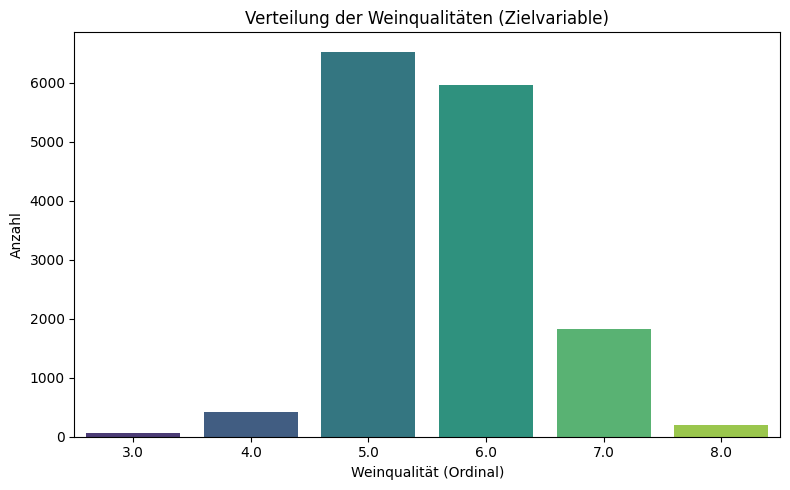

In [5]:
# 4. Zielverteilung anzeigen
plt.figure(figsize=(8, 5))
sns.countplot(x="quality", data=train_df, palette="viridis")
plt.title("Verteilung der Weinqualitäten (Zielvariable)")
plt.xlabel("Weinqualität (Ordinal)")
plt.ylabel("Anzahl")
plt.tight_layout()
plt.show()

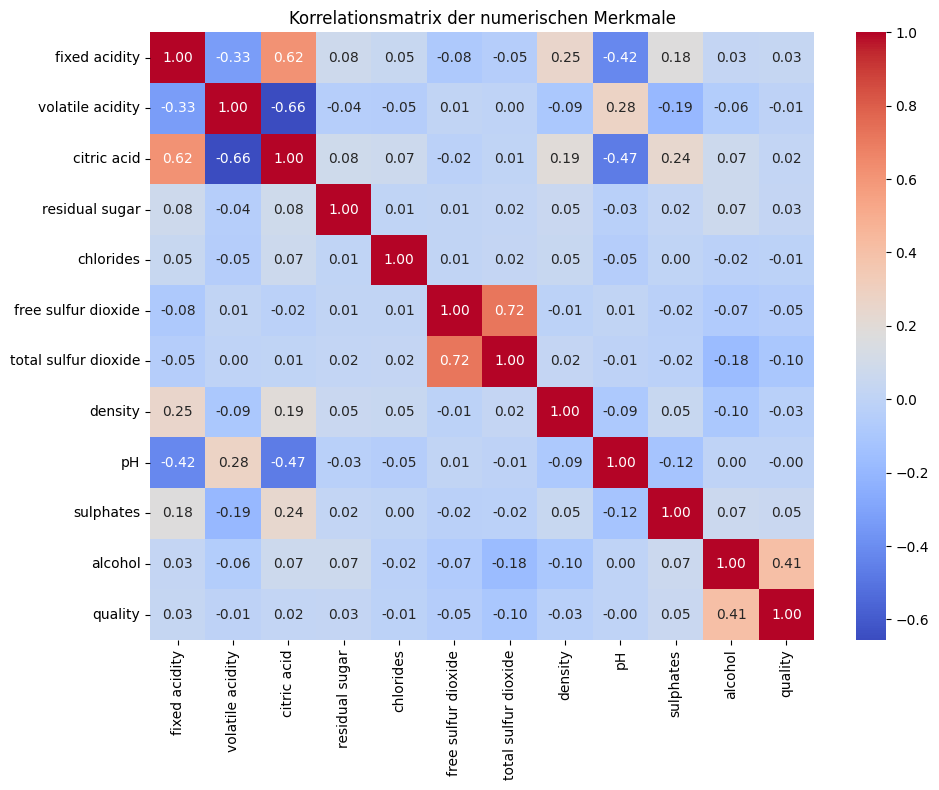

In [6]:
# 5. Korrelationsmatrix
plt.figure(figsize=(10, 8))
corr = train_df.drop(columns=["id"]).corr()
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Korrelationsmatrix der numerischen Merkmale")
plt.tight_layout()
plt.show()

C:\Users\ASUS\AppData\Local\Temp\ipykernel_29472\1526804785.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="quality", y="alcohol", data=train_df, palette="mako")


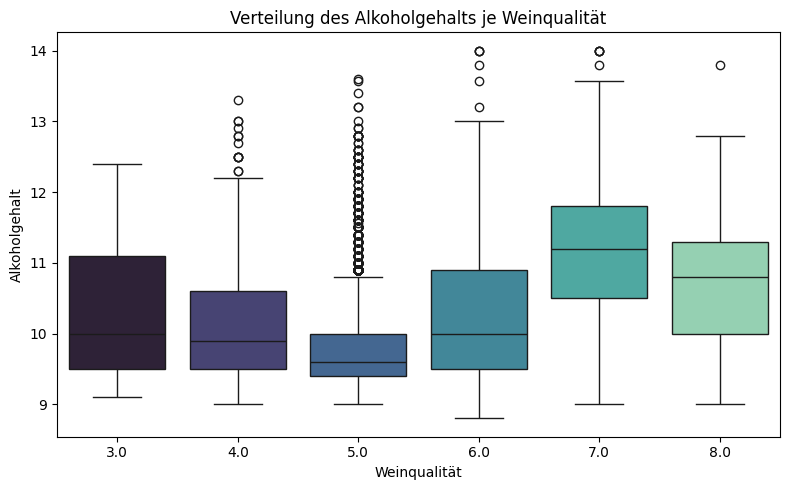

In [7]:
# 6. Alkoholgehalt je Qualitätsstufe
plt.figure(figsize=(8, 5))
sns.boxplot(x="quality", y="alcohol", data=train_df, palette="mako")
plt.title("Verteilung des Alkoholgehalts je Weinqualität")
plt.xlabel("Weinqualität")
plt.ylabel("Alkoholgehalt")
plt.tight_layout()
plt.show()

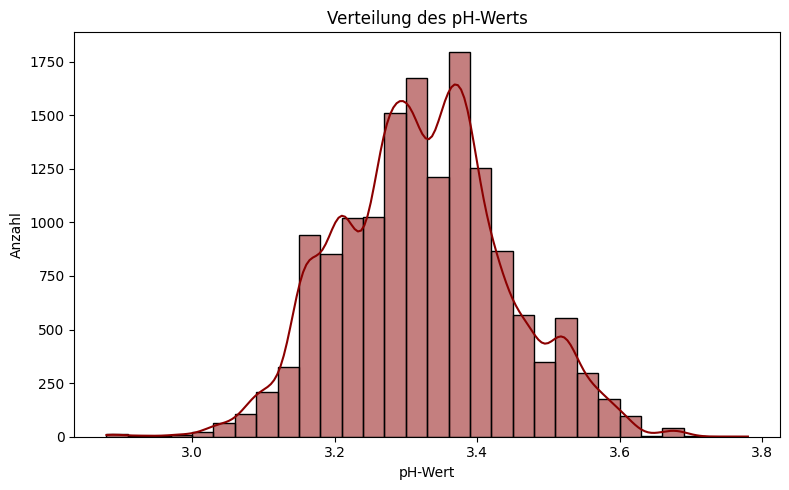

In [8]:
# 7. Verteilung des pH-Werts
plt.figure(figsize=(8, 5))
sns.histplot(train_df["pH"], kde=True, bins=30, color="darkred")
plt.title("Verteilung des pH-Werts")
plt.xlabel("pH-Wert")
plt.ylabel("Anzahl")
plt.tight_layout()
plt.show()

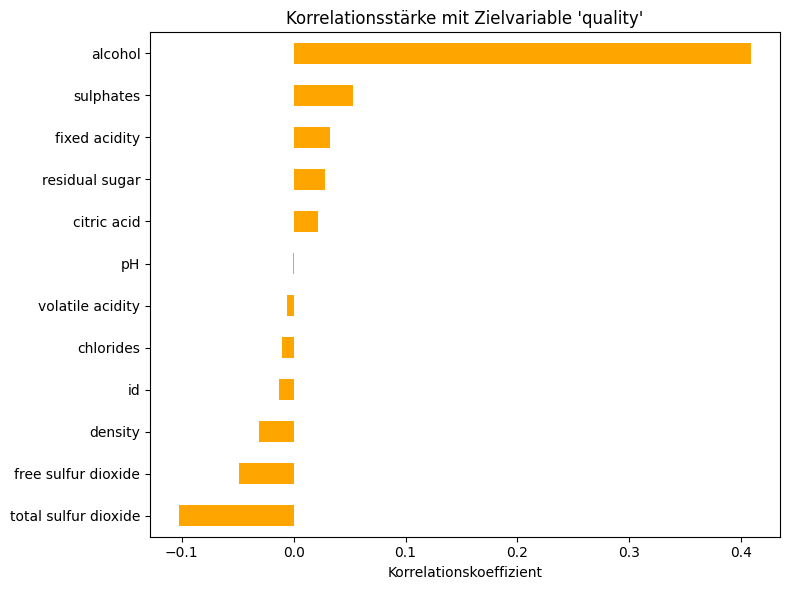

In [9]:
correlations = train_df.corr()["quality"].drop("quality").sort_values()
correlations.plot(kind="barh", figsize=(8, 6), color="orange")
plt.title("Korrelationsstärke mit Zielvariable 'quality'")
plt.xlabel("Korrelationskoeffizient")
plt.tight_layout()
plt.show()


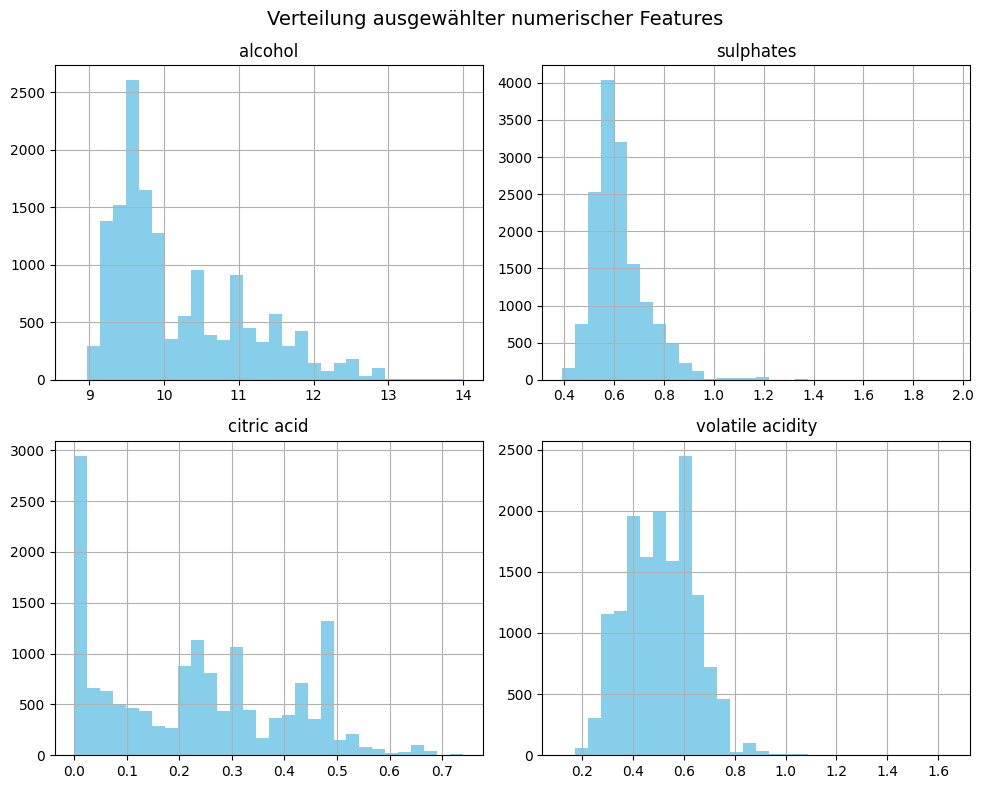

In [10]:
train_df[["alcohol", "sulphates", "citric acid", "volatile acidity"]].hist(
    bins=30, figsize=(10, 8), layout=(2, 2), color="skyblue"
)
plt.suptitle("Verteilung ausgewählter numerischer Features", fontsize=14)
plt.tight_layout()
plt.show()


In [11]:
# 8. Modelltraining: Klassifikation mit XGBoost (Label-Encoding notwendig)
# ------------------------------------------------------------------------
X = train_df.drop(columns=["id", "quality"])
y = train_df["quality"].astype(int)  # Wichtig: sicherstellen, dass es int ist

In [12]:
# Label-Encoding für y (wegen XGBoost-Anforderung)
le = LabelEncoder()
y_encoded = le.fit_transform(y)

In [13]:
# Split
X_train, X_val, y_train, y_val = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

In [14]:
# XGBoost-Klassifikator
model = XGBClassifier(
    n_estimators=300,
    max_depth=6,
    learning_rate=0.1,
    objective='multi:softmax',
    num_class=len(le.classes_),
    eval_metric='mlogloss',
    use_label_encoder=False,
    random_state=42
)
model.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric='mlogloss', gamma=0, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.1, max_bin=256,
              max_cat_to_onehot=4, max_delta_step=0, max_depth=6, max_leaves=0,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=300, n_jobs=0, num_class=6, num_parallel_tree=1,
              objective='multi:softmax', predictor='auto', random_state=42, ...)

In [15]:
# Vorhersage + Rücktransformation
y_pred_encoded = model.predict(X_val)
y_pred = le.inverse_transform(y_pred_encoded)
y_val_original = le.inverse_transform(y_val)

In [16]:
# Bewertung
print("\nKlassifikationsbericht:")
print(classification_report(y_val_original, y_pred, zero_division=0))


Klassifikationsbericht:
              precision    recall  f1-score   support

           3       0.00      0.00      0.00        13
           4       0.00      0.00      0.00        82
           5       0.59      0.73      0.65      1292
           6       0.49      0.47      0.48      1192
           7       0.46      0.29      0.35       375
           8       0.00      0.00      0.00        46

    accuracy                           0.54      3000
   macro avg       0.26      0.25      0.25      3000
weighted avg       0.50      0.54      0.52      3000



In [17]:
print("\nGenauigkeit (Accuracy):", accuracy_score(y_val_original, y_pred))


Genauigkeit (Accuracy): 0.5396666666666666


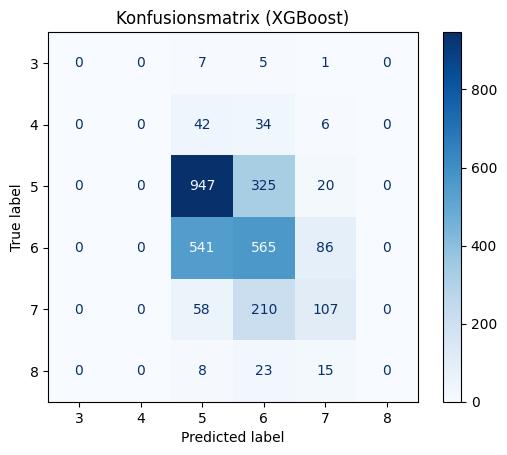

In [18]:
from sklearn.metrics import ConfusionMatrixDisplay

# Alternative Darstellung
ConfusionMatrixDisplay.from_predictions(y_val_original, y_pred, cmap="Blues")
plt.title("Konfusionsmatrix (XGBoost)")
plt.show()


In [19]:
#.Modell speichern mit Joblib

joblib.dump(model, "wine_quality_model_xgb.pkl")
print("\n💾 Modell wurde als 'wine_quality_model_xgb.pkl' gespeichert.")


💾 Modell wurde als 'wine_quality_model_xgb.pkl' gespeichert.


In [20]:
# Submission-Vorlage erstellen

test_features = test_df.drop(columns=["id"])
test_preds_encoded = model.predict(test_features)
test_preds = le.inverse_transform(test_preds_encoded)

submission = pd.DataFrame({
    "id": test_df["id"],
    "quality": test_preds
})

In [21]:
submission.to_csv("submission.csv", index=False)
print("\n✅ submission.csv wurde gespeichert.")


✅ submission.csv wurde gespeichert.


In [22]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import to_categorical

# One-Hot-Encoding für y
y_cat = to_categorical(y_encoded)

# Split
X_train, X_val, y_train, y_val = train_test_split(X, y_cat, test_size=0.2, random_state=42)

model = Sequential([
    Dense(128, activation='relu', input_shape=(X.shape[1],)),
    Dense(64, activation='relu'),
    Dense(y_cat.shape[1], activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=50, batch_size=32)


Epoch 1/50


C:\Users\ASUS\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


375/375 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.4335 - loss: 1.4174 - val_accuracy: 0.3973 - val_loss: 1.2739
Epoch 2/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.4627 - loss: 1.1748 - val_accuracy: 0.4237 - val_loss: 1.1815
Epoch 3/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.4647 - loss: 1.1405 - val_accuracy: 0.4847 - val_loss: 1.1295
Epoch 4/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.4863 - loss: 1.1332 - val_accuracy: 0.5047 - val_loss: 1.1291
Epoch 5/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.5126 - loss: 1.0983 - val_accuracy: 0.5163 - val_loss: 1.0928
Epoch 6/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.5161 - loss: 1.0730 - val_accuracy: 0.4543 - val_loss: 1.0993
Epoch 7/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.5116 - loss: 1.0813 - val_accuracy: 0.5007 - val_loss: 1.0833
Epoch 8/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.5112 - loss: 1.0889 - val_accuracy: 0.5210 - val_

In [25]:
# DL-Modell als modernes Keras-Format speichern
model.save("wine_quality_model_dl.keras")
print("💾 Modell wurde als 'wine_quality_model_dl.keras' gespeichert.")

💾 Modell wurde als 'wine_quality_model_dl.keras' gespeichert.
